# 제4장 Matrix Factorization(MF) 기반 추천

**메모리 기반 알고리즘** : 추천을 위한 데이터를 모두 메모리에 가지고 있으면서 추천이 필요할 때마다 이데이터를 사용해서 계산을 해서 추천하는 방식  
   - ex) CF

<br>

**모델 기반 추천** : 추천을 위한 모델을 구성한 후에 이 모델만 저장하고, 실제 추천을 할 때에는 이 모델을 사용해서 추천을 하는 방식  
   - ex) MF, Deep-Learning 방식의 추천도 데이터

<br>

메모리 기반 추천은 모든 데이터를 메모리에 저장하고 있기 때문에 원래 데이터를 충실하게 사용하는 장점이 있지만 대량의 데이터를 다뤄야 하는 상용 사이트에서는 계산시간이 너무 오래 걸린다는 단점이 있다  
이에 비해 모델 기반 추천 방식은 원래 데이터는 모형을 만드는 데만 사용하고 일단 모델이 만들어진면 원래 데이터는 사용하지 않기 때문에 대규모 상용 사이트에서 필요한 빠른 반응이 가능하지만 모델을 만드는 과정에서 많은 계산이 필요하다는 단점이 있다.  
일반적으로 메모리 기반 추천은 개별 사용자의 데이터에 집중하는 데 비해, 모델 기반 추천은 전체 사용자의 평가 패턴으로부터 모델을 구성하기 때문에 데이터가 가지고 있는 약한 신호 (weak signal)도 더 잘 잡아내는 장점이 있다.  
  - 약한신호 : 개별 사용자의 행동분석에서는 잘 드러나지 않는 패턴


## 4.1 Matrix Factorization(MF) 방식의 원리

<br>

행렬요인화는 평가 데이터, 즉 (사용자 x 아이템)으로 구성된 하나의 행렬을 2개의 행렬로 분해하는 방법


$R \approx P \times Q^T = \hat{R} $
- R : Rating matrix
- P : User latent matrix(사용자 잠재요인행렬)
- Q : Item latent matrix(아이템 잠재요인행렬)

<br>

MF 방식은 이 R행렬을 사용자행렬(P)과 아이템행렬(Q)로 쪼개어 분석하는 것  
- P는 (M x K), Q는 (N x K)  
- 여기서 $\hat{R}$은 R의 예측치이며 $\hat{R}$이 최대한 R에 가까운 값을 가지도록 하는 P와 Q를 구하면 그것이 바로 추천을 위한 모델이 된다
- P는 각 사용자의 특성을 나타내는 K개 요인의 값으로 이루어진 행렬, Q는 각 아이템의 특성을 나타내는 K개의 요인의 값으로 이루어진 행렬
- P와 Q행렬에서 공통인 K개의 요인이 있는데, 이를 잠재요인(latent factor)이라고 부른다.
- 즉 사용자와 아이템의 특성을 K개의 잠재요인을 사용해서 분석하는 모델이라고 한다



## 4.2 SGD(Stochastic Gradient Descent)를 사용한 MF 알고리즘

<br>

주어진 (사용자x아이템)의 평점행렬인 R로부터 P와Q를 분해하는 알고리즘
1. 잠재요인의 개수인 K를 정한다. K는 경험에 의해 직관적으로 정해도 되고 다양한 K를 비교하면서 최적의 수를 정해도 된다.
2. 주어진 K에 따라 P(MxK)와 Q(NxK)행렬을 만들고 초기화한다. 맨 처음에는 P,Q 행렬을 임의의 수로 채우는 것이 보통이다.
3. 주어진 P,Q 행렬을 사용해서 예측 평점 $\hat{R}(=P \times Q^T)$을 구한다
4. R에 있는 실제 평점에 대해서 예측 평점 $\hat{R}$의 예측과 비교해서 오차를 구하고, 이 오차를 줄이기 위해서 P,Q값을 수정한다
5. 전체 오차가 미리 정해진 기준값 이하가 되거나 미리 정해진 반복 횟수에 도달할 때까지 3번으로 돌아것 반복한다
<br>

여기서 핵심은 4번에서 예측 오차를 줄이기 위해서 P,Q를 어떻게 수정하는가이다  
가장 일반적인 방법은 기계학습에서 많이 사용되는 SGD(Stochastic Gradient Descent) 방법을 적용하는 것이다 

<br>


$L = \frac{1}{2} \sum_{(i,j) \in \Omega} \left( R_{ij} - P_i Q_j^\top \right)^2 + \frac{\lambda}{2} \left( \|P\|_F^2 + \|Q\|_F^2 \right)$

![확률적 경사하강법](image/이미지_4-1.png)

<br>

![정규화항](image/이미지_4-2.png)

- b : 전체 평균
- $bu_i$ : 전체 평균을 제거한 후 사용자 i의 평가경향(사용자 i의 평균과 전체 평균의 차이)
- $bd_j$ : 전체 평균을 제거한 후 아이템 j의 평가경향(아이템 j의 평균과 천체 평균의 차이)

## 4.3 SGD를 사용한 MF 기본 알고리즘


In [1]:
import pandas as pd
import numpy as np

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.data',sep='\t',names=r_cols,encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

# MF class
class MF():
    def __init__(self,ratings,k,alpha,beta,iterations,verbose=True):
        self.R = np.array(ratings)
        self.num_users,self.num_items = np.shape(self.R)
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose =verbose # SGD의 중간 학습과정을 출력할 것인가
        
    # Root Mean Squared Error(RMSE) 계산
    def rmse(self):
        # R에서 평점이 있는(0이 아닌) 요소의 인덱스를 가져온다
        xs,ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x,y in zip(xs,ys):
            prediction = self.get_prediction(x,y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y]-prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
    
    # 정해진 반복 횟수만큼 앞의 식 2번,4번을 사용해서 P,Q,bu,bd 값을 업데이트하는 함수
    def train(self):
        # Initializing user-feature and movie-feature matrix
        # 행렬을 임의의 값으로 채운다. 여기서는 평균 0, 표준편차 1/K인 정규분포를 갖는 난수로 초기화한다.
        self.P = np.random.normal(scale=1./self.k,size=(self.num_users,self.k)) # K가 커질수록 행렬의 각 원소는 더 많은 잠재요인들과 조합, 이때 초기값의 범위를 너무 넓게 설정하면 모델의 표현 범위가 불필요하게 커져 학습 과정에서 불안정성이 증가 또 너무 작은 초기값을 가지면 학습 속도가 느려지고 모델이 충분히 다양한 방향으로 학습되지 않을 수 있다
        self.Q = np.random.normal(scale=1./self.k,size=(self.num_items,self.k))
        
        #Initializing the bias terms
        # bu,bd를 0으로 초기화
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        # 0이 아닌 전체 평점 평균을 b에 저장
        self.b = np.mean(self.R[self.R.nonzero()])
        
        # List of training samples
        rows,columns = self.R.nonzero()
        # 평점이 있는 요소의 인덱스, 평점을 리스트로 저장
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows,columns)]
        
        # SGD for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse=self.rmse()
            training_process.append((i+1,rmse))
            if self.verbose:
                if (i+1)%10==0:
                    print("Iteration: %d ; Train RMSE = %.4f"%(i+1,rmse))
        return training_process

    # Rating prediction for user i and item j
    def get_prediction(self,i,j):
        prediction = self.b+self.b_u[i]+self.b_d[j]+self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    # SGD to get optimized P and Q matrix
    def sgd(self):
        for i,j,r in self.samples:
            prediction = self.get_prediction(i,j)
            e = (r-prediction)
            
            # 앞의 4번 식을 적용해서 bu,bd 업데이트
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])
            
            # 앞의 2번 식을 적용해서 P,Q 업데이트
            self.P[i,:] += self.alpha*(e*self.Q[j,:] - self.beta*self.P[i,:])
            self.Q[j,:] += self.alpha*(e*self.P[i,:] - self.beta*self.Q[j,:])
    

In [20]:
# 전체 데이터 사용 MF
# dataframe 형식을 full matrix로 변환 -> MF 클래스 내부적으로 full matrix(self.R)를 계산에 사용하기 때문
R_temp = ratings.pivot(index = 'user_id',columns = 'movie_id',values = 'rating').fillna(0)
mf = MF(R_temp,k=30,alpha=0.001,beta=0.02,iterations=100,verbose=True)
train_process = mf.train()

Iteration: 10 ; Train RMSE = 0.9585
Iteration: 20 ; Train RMSE = 0.9373
Iteration: 30 ; Train RMSE = 0.9280
Iteration: 40 ; Train RMSE = 0.9225
Iteration: 50 ; Train RMSE = 0.9183
Iteration: 60 ; Train RMSE = 0.9144
Iteration: 70 ; Train RMSE = 0.9099
Iteration: 80 ; Train RMSE = 0.9037
Iteration: 90 ; Train RMSE = 0.8948
Iteration: 100 ; Train RMSE = 0.8828


## 4.4 train/test 분리 MF 알고리즘

<br>

CF에서는 sklearn의 train_test_split을 사용했는데 여기서는 sklearn의 shuffle을 사용

In [2]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
# dataframe 형식으로 되어있는 ratings를 무작위로 섞는다
ratings = shuffle(ratings,random_state=1) # random_state : 랜덤 시드

# 전체 데이터 중 train 데이터 개수
cutoff = int(TRAIN_SIZE*len(ratings))
ratings_train = ratings.iloc[:cutoff] # iloc[] : 정수 기반 인덱싱, 행과 열의 숫자 위치로 기반
ratings_test = ratings.iloc[cutoff:]

user_id와 item_id를 각각의 인덱스와 매핑하는 user_id_index,item_id_index가 클래스 속성으로 추가된 것.  
이것이 필요한 이유는 user_id와 item_id가 내부의 인덱스와 일치하지 않기 때문이다.  
user_id와 item_id가 연속값이 아닐 수도 있다 이 경우 데이터는 클래스 내부에서 numpy array인 self.R로 변환되면서 중간이 비어있는 실제 아이디와 R의 인덱스가 일치하지 않게 된다. 왜냐하면 numpy array는 무조건 연속되는 값이 지정되지만 아이디는 그렇지 않기 때문
- 연속된 값 ex) 0,1,2 ...

In [3]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, k, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        # user_id, item_id를 R의 index와 매핑하기 위한 dictionary
        item_id_index = []
        index_item_id = []
        for i,one_id in enumerate(ratings): # enumerate : (인덱스,값) 형식의 튜플을 생성하여 반환
            item_id_index.append([one_id,i])
            index_item_id.append([i,one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        
        user_id_index = []
        index_user_id = []
        for i,one_id in enumerate(ratings.T):
            user_id_index.append([one_id,i])
            index_user_id.append([i,one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        self.num_users, self.num_items = np.shape(self.R)
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose
        
    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # SGD to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
    
    # Test set 선정
    def set_test(self,ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            # ratings_test에서 index 뽑아오기 (0:유저, 1:아이템, 2:평점)
            x = self.user_id_index[ratings_test.iloc[i,0]]
            y = self.item_id_index[ratings_test.iloc[i,1]]
            z = ratings_test.iloc[i,2]
            test_set.append([x,y,z])
            # 해당 (사용자-아이템-평점)을 R에서 0으로 지운다 -> R을 사용해서 MF모델을 학습을 하기 때문에 test set은 R에서 제거해야 한다
            self.R[x,y] = 0
        self.test_set = test_set
        return test_set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0],one_set[1])
            error += pow(one_set[2]-predicted,2)
        return np.sqrt(error/len(self.test_set))
    
    def test(self):
        self.P = np.random.normal(scale=1./self.k,size=(self.num_users,self.k))
        self.Q = np.random.normal(scale=1./self.k,size=(self.num_items,self.k))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])
        
        row,columns = self.R.nonzero()
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(row,columns)]
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            # train set의 rmse
            rmse1 = self.rmse()
            # test set의 rmse
            rmse2 = self.test_rmse()
            training_process.append((i+1,rmse1,rmse2))
            if self.verbose:
                if (i+1)%10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f"%(i+1,rmse1,rmse2))
        return training_process
    
    # 주어진 user_id와 item_id에 대한 예측치
    def get_one_prediction(self,user_id,item_id):
        return self.get_prediction(self.user_id_index[user_id],self.item_id_index[item_id])
    
    # 앞의 식 3번에 따라 모든 사용자의 모든 아이템에 대한 예측치(full matrix)를 계산해서 돌려준다
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] +self.b_d[np.newaxis,:] + self.P.dot(self.Q.T) # np.newaxis : 배열의 차원을 확장
    
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id',columns='movie_id',values='rating').fillna(0)
mf = NEW_MF(R_temp,k=30,alpha=0.001,beta=0.02,iterations=100,verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

# 전체 예측치
print(mf.full_prediction())
# 개별 예측치
print(mf.get_prediction(1,2))

Iteration: 10 ; Train RMSE = 0.9659 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9410 ; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9298 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9230 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9183 ; Test RMSE = 0.9496
Iteration: 60 ; Train RMSE = 0.9144 ; Test RMSE = 0.9478
Iteration: 70 ; Train RMSE = 0.9106 ; Test RMSE = 0.9463
Iteration: 80 ; Train RMSE = 0.9065 ; Test RMSE = 0.9450
Iteration: 90 ; Train RMSE = 0.9015 ; Test RMSE = 0.9435
Iteration: 100 ; Train RMSE = 0.8950 ; Test RMSE = 0.9416
[[3.8310796  3.40450863 3.07912732 ... 3.33954345 3.45849851 3.44459865]
 [3.92112687 3.48917323 3.17945204 ... 3.40953848 3.54356612 3.53594085]
 [3.31286303 2.89316299 2.5668828  ... 2.80355739 2.93384472 2.93126323]
 ...
 [4.2163712  3.78120911 3.42653732 ... 3.70915111 3.83387884 3.82616531]
 [4.33631707 3.90810648 3.5659206  ... 3.83990981 3.95627306 3.95033172]
 [3.80204685 3.36351619 3.05286902 ... 3.26753666 3.4263918

### 연습문제

4.1 train/test set을 분리하는 방법을 shuffle() 대신에 앞장에서 사용한 train_test_split()을 사용해서 분리하도록 수정하고 실행해 보세요.

In [6]:
from sklearn.model_selection import train_test_split
ratings_train_1 , ratings_test_1 = train_test_split(ratings,test_size=0.25,random_state=42)

print(ratings_test.head())
print(ratings_test_1.head())

       user_id  movie_id  rating
53670      345       715       4
77110       92       998       2
69323      934       195       4
85968      586       423       2
30243      336       383       1
       user_id  movie_id  rating
3141        83       364       1
95896      451       990       3
37382      344       174       5
73045      798       377       3
76085      847        93       1


In [8]:
# Testing MF RMSE
# 기존의 R_temp는 전체 데이터를 기반으로 생성 따라서 split으로 분리한 의미가없다
# 연습문제의 R_temp는 훈련 데이터로만 만들어져야한다
R_temp = ratings_train_1.pivot(index='user_id',columns='movie_id',values='rating').fillna(0)
mf = NEW_MF(R_temp,k=30,alpha=0.001,beta=0.02,iterations=100,verbose=True)

# test 데이터의 인덱스가 train데이터에 없기 때문에 오류발생
# 따라서 test 데이터에서 train 데이터 안에 없는 인덱스 삭제
ratings_test_1_filtered = ratings_test_1[
    (ratings_test_1['user_id'].isin(mf.user_id_index)) & 
    (ratings_test_1['movie_id'].isin(mf.item_id_index))
]
test_set = mf.set_test(ratings_test_1_filtered)
result = mf.test()

# 전체 예측치
print(mf.full_prediction())
# 개별 예측치
print(mf.get_prediction(1,2))

Iteration: 10 ; Train RMSE = 0.9698 ; Test RMSE = 0.9707
Iteration: 20 ; Train RMSE = 0.9447 ; Test RMSE = 0.9518
Iteration: 30 ; Train RMSE = 0.9334 ; Test RMSE = 0.9442
Iteration: 40 ; Train RMSE = 0.9265 ; Test RMSE = 0.9402
Iteration: 50 ; Train RMSE = 0.9217 ; Test RMSE = 0.9377
Iteration: 60 ; Train RMSE = 0.9177 ; Test RMSE = 0.9361
Iteration: 70 ; Train RMSE = 0.9139 ; Test RMSE = 0.9348
Iteration: 80 ; Train RMSE = 0.9098 ; Test RMSE = 0.9336
Iteration: 90 ; Train RMSE = 0.9046 ; Test RMSE = 0.9321
Iteration: 100 ; Train RMSE = 0.8980 ; Test RMSE = 0.9303
[[3.96880232 3.31234044 3.10347069 ... 3.35560176 3.50258605 3.4636526 ]
 [3.92621897 3.31275063 3.09081387 ... 3.35640552 3.4909482  3.46483497]
 [3.38637729 2.7529703  2.53667333 ... 2.79457976 2.92862808 2.88415276]
 ...
 [4.29549143 3.69639873 3.45241815 ... 3.72400048 3.83982996 3.80225177]
 [4.38037387 3.78636196 3.55720907 ... 3.80455097 3.93357401 3.91491746]
 [3.7301589  3.19308851 2.91021176 ... 3.19888265 3.3077248

## 4.5 MF의 최적 파라미터 찾기

K(잠재요인),iterations,$\alpha$,$\beta$ 와 같은 다른 파라미터도 정확도에 영향을 미친다.  

<br>

K가 지나치게 커지면 train set에 지나치게 맞춰지는 과적합(over-fitting)이 발생한다. 그래서 K가 커짐에 따라 test set에 대한 정확도는 증가하다가 어느 지점 이후에는 오히려 감소하는 모습을 보인다.  
반복횟수 iterations도 마찬가지.  

<br>

최적의 K와 iterations를 찾는 예
1. 최적의 K가 대략 어떤 수인지 확인하기 위해 50부터 260까지 넓은 범위에 대해서 10 간격으로 정확도(RMSE)를 계산한다.
2. 최적의 RMSE를 보이는 K를 확인한 후 이 숫자 전후 +-10의 K에 대해서 1의 간격으로 다시 한번 RMSE를 계산해서 최적의 K값을 찾는다.
3. iterations는 학습과정에서 충분히 큰 숫자를 주어서 RMSE가 어떻게 변화하는지 관찰해서 주어진 K에 대해서 최적의 iterations값을 구한다.

정확도는 실행할때마다 달라지기 때문에 보통 코드 전체를 여러 번 실행해서 결과의 평균을 취하는 것이 보통이다.



In [9]:
# 최적의 K값 찾기
results = []
index = []
for k in range(50,261,10):
    print('k=',k)
    R_temp = ratings.pivot(index = 'user_id',columns = 'movie_id',values = 'rating').fillna(0)
    mf = NEW_MF(R_temp,k=k,alpha=0.001,beta=0.02,iterations=300,verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(k)
    results.append(result)

k= 50
Iteration: 10 ; Train RMSE = 0.9661 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9414 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9241 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9198 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9164 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9135 ; Test RMSE = 0.9466
Iteration: 80 ; Train RMSE = 0.9105 ; Test RMSE = 0.9455
Iteration: 90 ; Train RMSE = 0.9071 ; Test RMSE = 0.9443
Iteration: 100 ; Train RMSE = 0.9027 ; Test RMSE = 0.9430
Iteration: 110 ; Train RMSE = 0.8968 ; Test RMSE = 0.9412
Iteration: 120 ; Train RMSE = 0.8887 ; Test RMSE = 0.9388
Iteration: 130 ; Train RMSE = 0.8782 ; Test RMSE = 0.9357
Iteration: 140 ; Train RMSE = 0.8652 ; Test RMSE = 0.9321
Iteration: 150 ; Train RMSE = 0.8503 ; Test RMSE = 0.9285
Iteration: 160 ; Train RMSE = 0.8338 ; Test RMSE = 0.9253
Iteration: 170 ; Train RMSE = 0.8160 ; Test RMSE = 0.9225
Iteration: 180 ; 

In [11]:
# 최적의 iterations값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min) # min이 RMSE 리스트에서 처음으로 나타나는 위치를 j에 저장
    summary.append([index[i],j+1,RMSE[j]])

summary

[[50, 207, 0.9177019637346026],
 [60, 212, 0.915730791309124],
 [70, 218, 0.9131349235774273],
 [80, 225, 0.9134378907573648],
 [90, 227, 0.9134451833208723],
 [100, 233, 0.9127965301708123],
 [110, 237, 0.9118326341271404],
 [120, 239, 0.9115513901514052],
 [130, 241, 0.9115624939925505],
 [140, 242, 0.9108814595421894],
 [150, 243, 0.9112997165943104],
 [160, 246, 0.9116356073875228],
 [170, 249, 0.9100121406052449],
 [180, 254, 0.9093696724198735],
 [190, 251, 0.9105335210993174],
 [200, 255, 0.909969228062167],
 [210, 254, 0.909814855397133],
 [220, 256, 0.9089586079500345],
 [230, 257, 0.9105782080513936],
 [240, 257, 0.9097666783749361],
 [250, 259, 0.9095135459130043],
 [260, 258, 0.9094327543399708]]

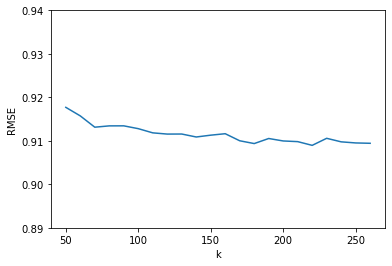

In [12]:
# 그래프로 그리기
import matplotlib.pyplot as plt
plt.plot(index,[x[2] for x in summary])
plt.ylim(0.89,0.94)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

숫자를 보면 k = 220에서 RMSE 0.908~이 가장 좋은 결과 이지만 k=200 이후로는 사실상 큰 변화가 없다.  
그래서 k=200을 최적의 k로 간주한다. 그리고 대략 iterations=250 정도에서 최적의 결과를 보여준다.  

<br>

K, $\alpha$, $\beta$ 와 같은 파라미터 각각에 대해서 최적값을 구했다 하더라도 이들을 단순히 조합한 것이 최적이라는 보장은 없다.  
그래서 보통은 파라미터 1의 최적값을 구해서 파라미터 1을 최적으로 고정한 다음에, 파라미터 2의 최적값을 구한다.  
모든 파라미터에 대해서 돌아가면서 한 번이나 두 번 정도씩만 최적값을 구해도 대략의 최적값 조합을 얻을 수 있다.